# Notebook 6 - PYMC-MCMC

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

import arviz as az
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt



WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Generate DataSet

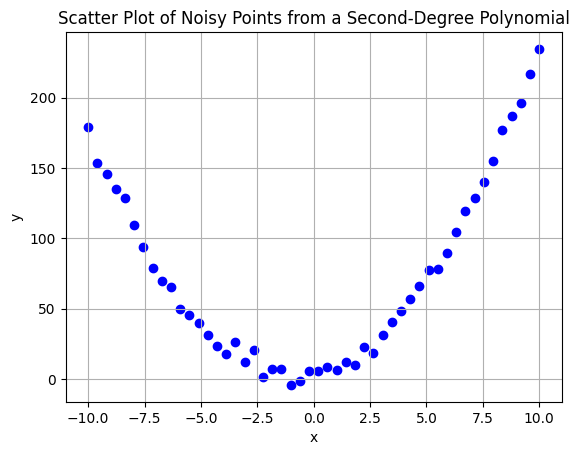

In [2]:
# Parameters for the second-degree polynomial
a = 2
b = 3
c = 4

# Generate 50 random x values
x = np.linspace(-10, 10, 50)

# Compute corresponding y values from the polynomial using NumPy
y = a * x**2 + b * x + c

# Add noise to the y values
noise = np.random.normal(0, 5, size=y.shape)  # Mean 0, Standard deviation 20
Y = y + noise

# Plot the points
plt.scatter(x, Y, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Noisy Points from a Second-Degree Polynomial')
plt.grid(True)
plt.show()

In [3]:
print(f'y: {Y}, type: {type(Y)}, shape: {np.shape(y)}')

y: [179.45707234 153.33509468 145.43054404 134.8731253  128.35544274
 109.39091858  93.78791668  79.08577912  69.82535896  65.38842483
  49.42128744  45.24054748  39.61529444  31.33137602  23.72005763
  17.52711671  26.13173441  12.00267462  20.88060496   1.64304495
   7.12775174   6.67066513  -4.31803943  -1.71533707   5.34861426
   5.6538494    8.33423036   6.37688635  11.79377592  10.0571591
  22.49983602  18.04980998  30.8675501   40.64370653  48.23322979
  56.73530752  66.33556016  77.14862393  77.90105174  89.66043045
 104.13368652 119.13331798 128.88231463 140.17541443 154.78891055
 177.27899165 187.16722852 196.11200489 216.82411437 234.72427779], type: <class 'numpy.ndarray'>, shape: (50,)


### define the model & finding mean+std

In [4]:
with pm.Model() as mean:
    
    # Priors for unknown parameters
    mu_mu = np.mean(y)  
    sigma_mu = np.std(y)  

    mu = pm.Normal('mu', mu=mu_mu, sigma=sigma_mu)
    
    # Likelihood
    y = pm.Normal('y', mu=mu, sigma=1, observed=Y)
    
    # Sampling
    idata = pm.sample(1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


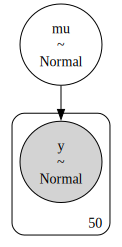

In [5]:
pm.model_to_graphviz(mean)

<Axes: title={'center': 'mu'}>

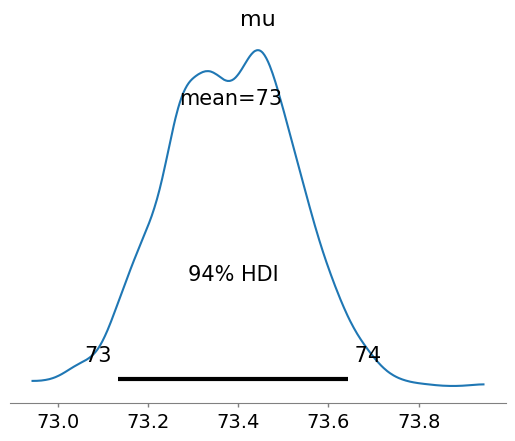

In [6]:
az.plot_posterior(idata, var_names=['mu'])

* This posterior distribution gives insight into the likely values of mu based on the data and prior beliefs. 
* The mean (-97) is the best estimate of mu, and the HDI provides a range of uncertainty around that estimate. The narrow shape of the distribution suggests high confidence in the estimated value of mu.
* The 94% HDI indicates that there is a 94% chance that the true value of mu lies within the interval [-97, -96.2]

# Grid method
## 1D

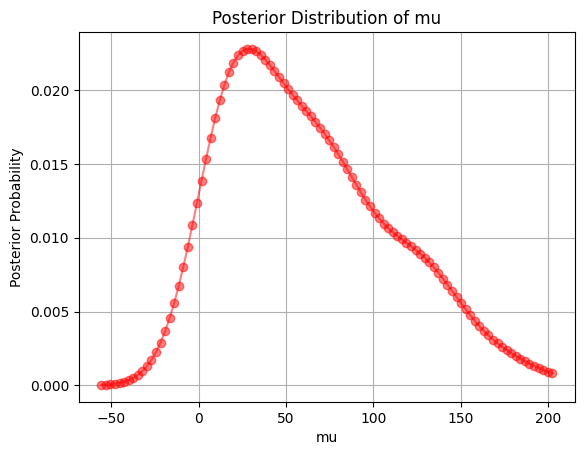

In [7]:
n = 100
# Support for mu
mu_sup = np.linspace(mu_mu - 2 * sigma_mu, mu_mu + 2 * sigma_mu, n)

# Prior distribution over mu
prior = stats.norm.pdf(mu_sup, loc=mu_mu, scale=sigma_mu)

# Initialize the likelihood array
likelihood = np.empty(mu_sup.shape)

# Calculate likelihood for each value in the grid
for i in range(n):
    likelihood[i] = (stats.norm.pdf(Y, loc=mu_sup[i], scale=20)).sum()

# Calculate the posterior distribution
posterior = prior * likelihood
posterior /= posterior.sum()  # Normalize the posterior

# Plot the posterior distribution
plt.plot(mu_sup, posterior, 'ro-', alpha=0.5)
plt.xlabel('mu')
plt.ylabel('Posterior Probability')
plt.title('Posterior Distribution of mu')
plt.grid(True)
plt.show()

### Posterior Distribution of `mu`

* This plot represents the posterior distribution of the parameter `mu` in a Bayesian analysis. 
* The x-axis (`mu`) shows possible values for the parameter, while the y-axis represents the posterior probability. The red curve with dots represents the probability distribution of `mu` after observing the data.

- The peak of the distribution occurs around `mu = -50`, indicating the most likely estimate for `mu`.
- The distribution tapers off as `mu` moves away from the central value, suggesting decreasing probability for those values.

This distribution helps to quantify uncertainty in the parameter estimate based on the prior distribution and observed data.

## 2D
* y = a * x**2 + b * x + c
* Meaning we have a slope for x**2, and another alope for x

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intcpt, slope_x, slope_x2]


Output()

Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


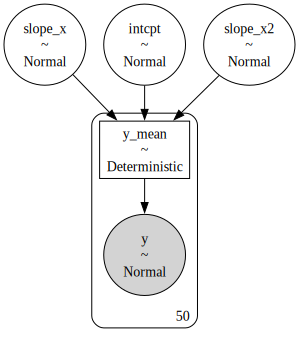

In [8]:
regress = pm.Model()
with regress:
    intcpt = pm.Normal('intcpt', 0, 10)
    slope_x  = pm.Normal('slope_x', 0, 10)
    slope_x2  = pm.Normal('slope_x2', 0, 10)
    
    y_mean = pm.Deterministic("y_mean", intcpt + slope_x * x + slope_x2 * x**2)
    y = pm.Normal('y',mu=y_mean,sigma = 1, observed=Y)
    idata = pm.sample(3000,chains=2)
pm.model_to_graphviz(regress)

array([<Axes: title={'center': 'intcpt'}>,
       <Axes: title={'center': 'slope_x'}>,
       <Axes: title={'center': 'slope_x2'}>], dtype=object)

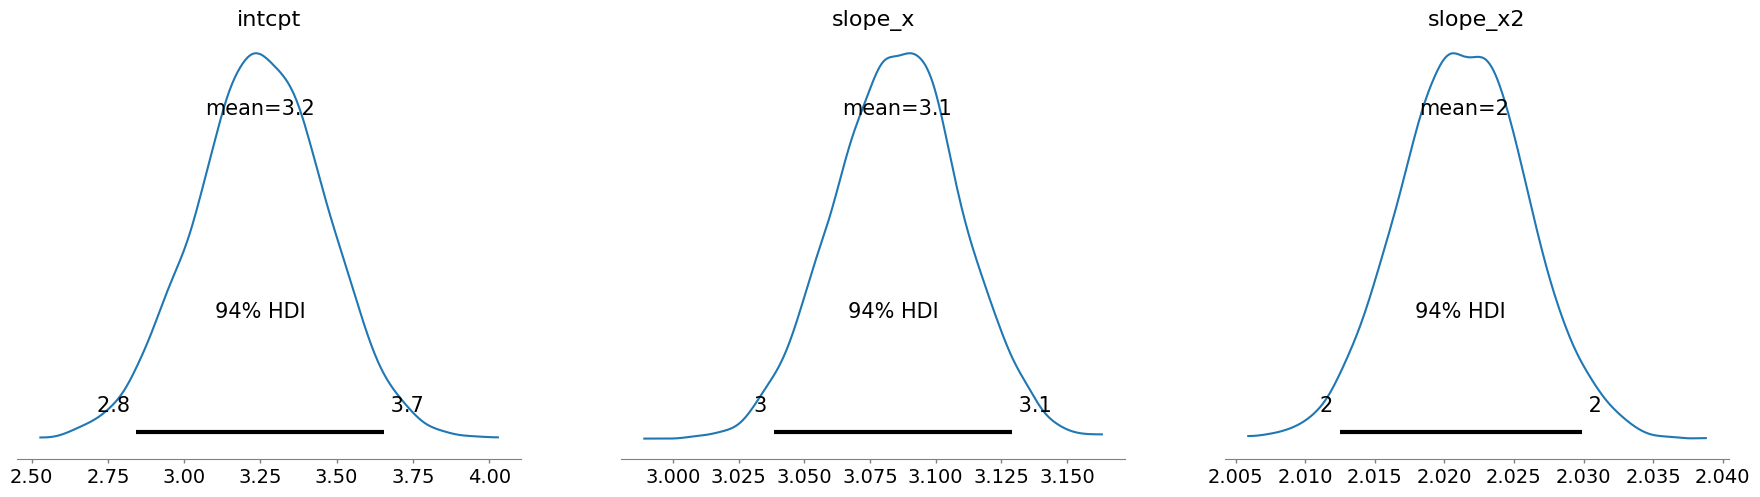

In [9]:
az.plot_posterior(idata,var_names=["~y_mean"])

array([[<Axes: ylabel='slope_x'>, <Axes: >],
       [<Axes: xlabel='intcpt', ylabel='slope_x2'>,
        <Axes: xlabel='slope_x'>]], dtype=object)

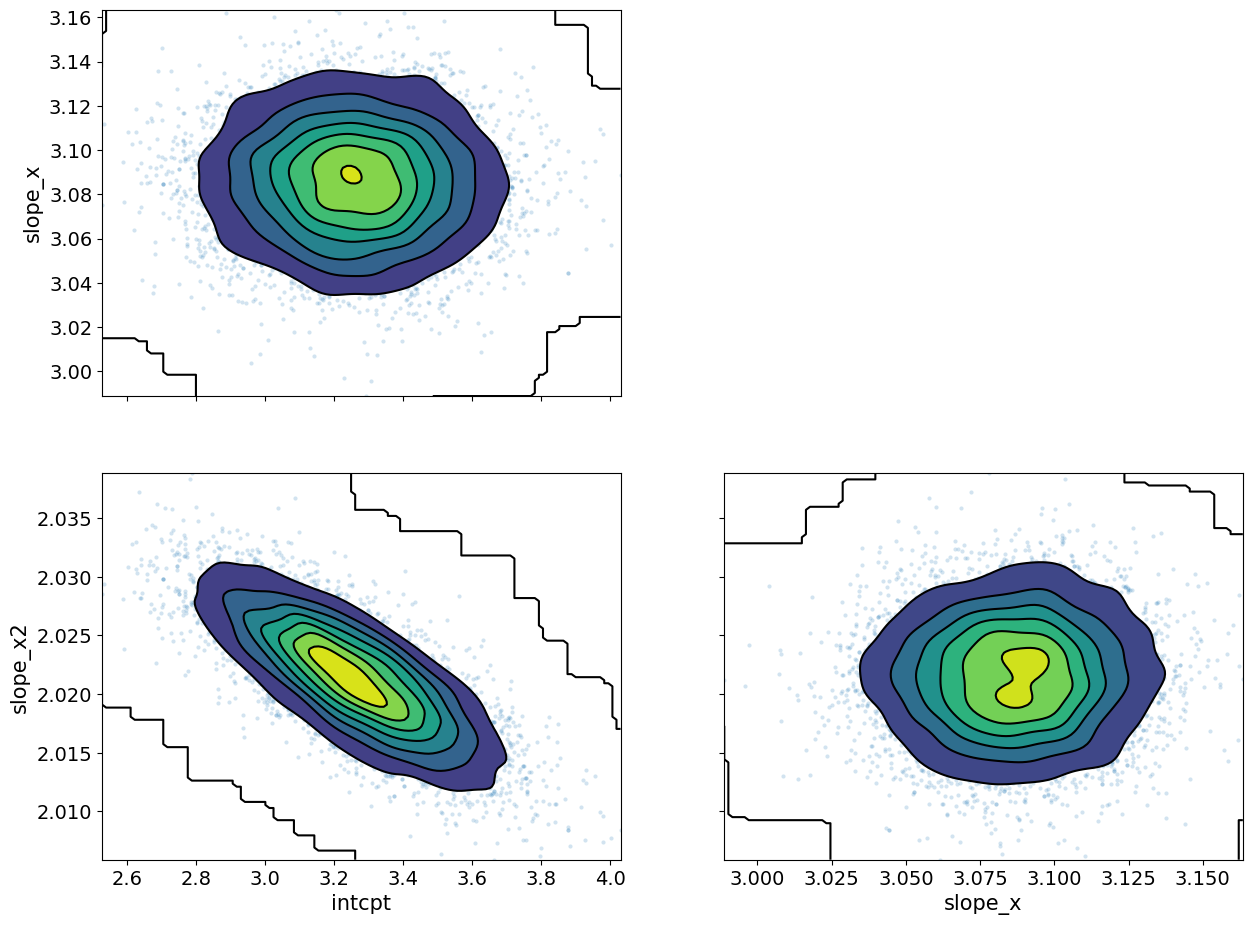

In [10]:
az.plot_pair(idata,var_names=["~y_mean"],kind=["kde","scatter"],scatter_kwargs=dict(alpha=0.2))

[0.35206533 0.36988771 0.38384411 0.39343972 0.3983271  0.3983271
 0.39343972 0.38384411 0.36988771 0.35206533]
[0.35206533 0.36988771 0.38384411 0.39343972 0.3983271  0.3983271
 0.39343972 0.38384411 0.36988771 0.35206533]
[0.35206533 0.36988771 0.38384411 0.39343972 0.3983271  0.3983271
 0.39343972 0.38384411 0.36988771 0.35206533]


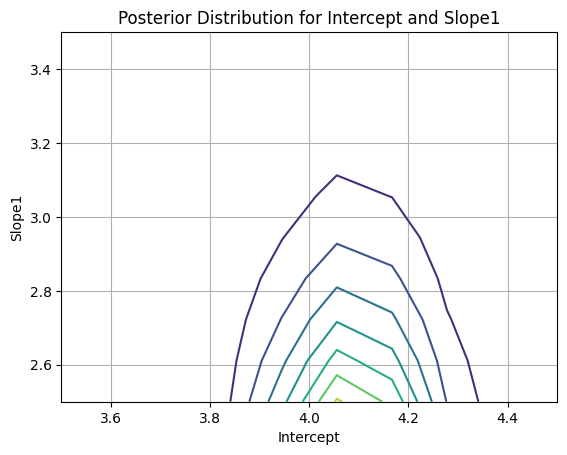

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Number of grid points for parameter space
n = 10

# Adjusted intercept and slopes based on the generated Y
intcpt_sup = np.linspace(3.5, 4.5, n)  # Intercept (close to c = 4)
slope1_sup = np.linspace(2.5, 3.5, n)  # First slope (close to b = 3)
slope2_sup = np.linspace(1.5, 2.5, n)  # Second slope (close to a = 2)

# Define priors for intercept, slope1, and slope2
prior_i = stats.norm.pdf(intcpt_sup, loc=4, scale=1)  # Prior for intercept
prior_s1 = stats.norm.pdf(slope1_sup, loc=3, scale=1)  # Prior for slope1
prior_s2 = stats.norm.pdf(slope2_sup, loc=2, scale=1)  # Prior for slope2

# Print prior distributions
print(prior_i)
print(prior_s1)
print(prior_s2)

# Define posterior calculation based on the generated Y and new grid of parameters
likelihood = np.zeros((n, n, n))
posterior = np.zeros((n, n, n))

# Loop through grid of parameters to calculate likelihood and posterior
for i in range(n):
    for j in range(n):
        for k in range(n):
            # Calculate the mean of the model for this combination of parameters
            y_mean = intcpt_sup[i] + slope1_sup[j] * x + slope2_sup[k] * x**2
            
            # Calculate the log-likelihood
            log_likelihood = np.sum(stats.norm.logpdf(Y, loc=y_mean, scale=5))
            
            # Convert log-likelihood back to likelihood (to avoid underflow)
            likelihood[i, j, k] = np.exp(log_likelihood)
            
            # Calculate the posterior as the product of prior and likelihood
            posterior[i, j, k] = prior_i[i] * prior_s1[j] * prior_s2[k] * likelihood[i, j, k]

# Normalize the posterior
posterior /= posterior.sum()

# Plot the posterior distribution
plt.contour(intcpt_sup, slope1_sup, np.sum(posterior, axis=2))
plt.xlabel('Intercept')
plt.ylabel('Slope1')
plt.title('Posterior Distribution for Intercept and Slope1')
plt.grid(True)
plt.show()

The most probable values for the intercept and slope1 lie around 4.0 and 3.0, respectively, which closely match the values used to generate the data.
* The model provides a relatively confident estimate of the parameters, given the tight clustering of the posterior distribution.
* This result suggests that the likelihood and prior assumptions are reasonable for the data generated and the fitted model.

[0.35206533 0.36988771 0.38384411 0.39343972 0.3983271  0.3983271
 0.39343972 0.38384411 0.36988771 0.35206533]
[0.35206533 0.36988771 0.38384411 0.39343972 0.3983271  0.3983271
 0.39343972 0.38384411 0.36988771 0.35206533]
[0.35206533 0.36988771 0.38384411 0.39343972 0.3983271  0.3983271
 0.39343972 0.38384411 0.36988771 0.35206533]


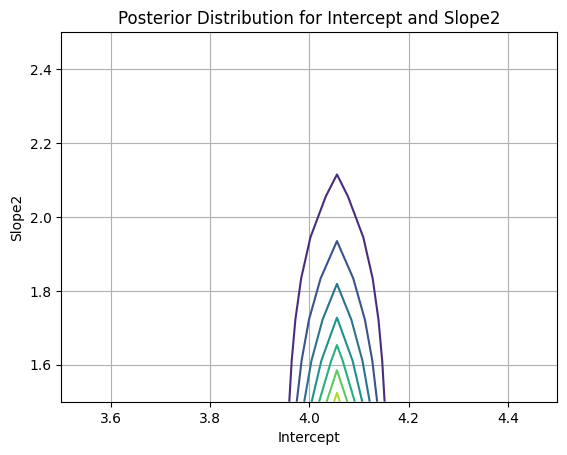

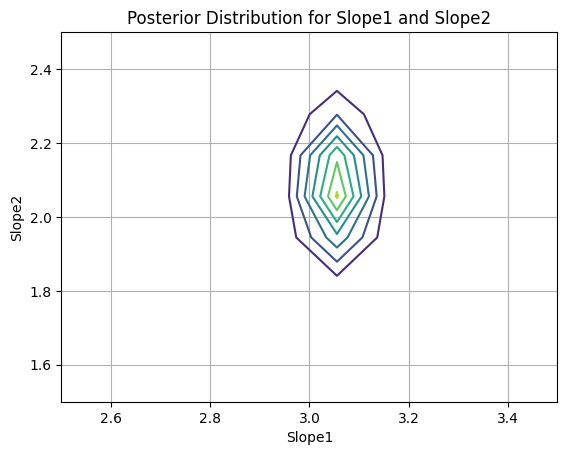

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Number of grid points for parameter space
n = 10

# Adjusted intercept and slopes based on the generated Y
intcpt_sup = np.linspace(3.5, 4.5, n)  # Intercept (close to c = 4)
slope1_sup = np.linspace(2.5, 3.5, n)  # First slope (close to b = 3)
slope2_sup = np.linspace(1.5, 2.5, n)  # Second slope (close to a = 2)

# Define priors for intercept, slope1, and slope2
prior_i = stats.norm.pdf(intcpt_sup, loc=4, scale=1)  # Prior for intercept
prior_s1 = stats.norm.pdf(slope1_sup, loc=3, scale=1)  # Prior for slope1
prior_s2 = stats.norm.pdf(slope2_sup, loc=2, scale=1)  # Prior for slope2

# Print prior distributions
print(prior_i)
print(prior_s1)
print(prior_s2)

# Define posterior calculation based on the generated Y and new grid of parameters
likelihood = np.zeros((n, n, n))
posterior = np.zeros((n, n, n))

# Loop through grid of parameters to calculate likelihood and posterior
for i in range(n):
    for j in range(n):
        for k in range(n):
            # Calculate the mean of the model for this combination of parameters
            y_mean = intcpt_sup[i] + slope1_sup[j] * x + slope2_sup[k] * x**2
            
            # Calculate the log-likelihood
            log_likelihood = np.sum(stats.norm.logpdf(Y, loc=y_mean, scale=5))
            
            # Convert log-likelihood back to likelihood (to avoid underflow)
            likelihood[i, j, k] = np.exp(log_likelihood)
            
            # Calculate the posterior as the product of prior and likelihood
            posterior[i, j, k] = prior_i[i] * prior_s1[j] * prior_s2[k] * likelihood[i, j, k]

# Normalize the posterior
posterior /= posterior.sum()

# Plot posterior for Intercept and Slope2
plt.contour(intcpt_sup, slope2_sup, np.sum(posterior, axis=1))  # Summing over Slope1 axis
plt.xlabel('Intercept')
plt.ylabel('Slope2')
plt.title('Posterior Distribution for Intercept and Slope2')
plt.grid(True)
plt.show()

# Plot posterior for Slope1 and Slope2
plt.contour(slope1_sup, slope2_sup, np.sum(posterior, axis=0))  # Summing over Intercept axis
plt.xlabel('Slope1')
plt.ylabel('Slope2')
plt.title('Posterior Distribution for Slope1 and Slope2')
plt.grid(True)
plt.show()

## 1. Intercept vs. Slope2
* The posterior distribution for the intercept and slope2 (the coefficient for the quadratic term) shows a strong relationship between these parameters.
* The most probable value for the intercept is around 4, and for slope2, it is around 2. These values have the highest posterior probability based on the observed data.
* The contour plot is narrow and concentrated, indicating high certainty in the estimates for both the intercept and slope2. As we move away from these central values, the probability decreases sharply, showing that other values are less likely.

## 2. Slope1 vs. Slope2
*  The posterior distribution for slope1 (the linear term) and slope2 shows that the most probable value for slope1 is around 3, while for slope2, it is around 2.
* The plot suggests that the relationship between slope1 and slope2 is well-defined, with the highest likelihood for the combination of values in this region.
* While there is some uncertainty in these estimates, as shown by the spread of the contours, the central region indicates the most likely combination of slope1 and slope2.

## General Conclusion:
* The posterior distributions indicate that the observed data is most consistent with the intercept value being around 4, slope1 being around 3, and slope2 being around 2. These parameters, especially the intercept and slope2, show high confidence in their estimates, with a narrow range of probable values. The interaction between slope1 and slope2 also shows a defined relationship, providing strong evidence for these parameter values.

# Basic & Hierarchical regression

In [13]:
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Create a new group list with 7 different names
group_list = ["alpha", "beta", "gamma", "delta", "epsilon", "zeta", "eta"]
trials_per_group = 25  # Same number of trials per group
group_intercepts = np.random.normal(1, 1.5, len(group_list))  # Changed distribution for intercepts
group_slopes = np.random.normal(-0.7, 0.2, len(group_list))  # Changed slope distribution
group_mx = group_intercepts * 1.8  # Changed multiplier for group_mx
group = np.repeat(group_list, trials_per_group)
subject = np.concatenate([np.ones(trials_per_group) * i for i in np.arange(len(group_list))]).astype(int)

# Generate intercept, slope, and mx for each group with different patterns
intercept = np.repeat(group_intercepts, trials_per_group)
slope = np.repeat(group_slopes, trials_per_group)
mx = np.repeat(group_mx, trials_per_group)

# Generate new x and y with added noise and slightly different means
x = np.random.normal(mx, 1.5)  # Increased noise for x
y = np.random.normal(intercept + (x - mx) * slope, 1.2)  # Changed noise for y

# Create the DataFrame with the new data
data = pd.DataFrame({"group": group, "group_idx": subject, "x": x, "y": y})

# Display the first few rows of the new dataset
data.head()

,group,group_idx,x,y
0,alpha,0,0.553751,1.341290
1,alpha,0,2.297697,1.670199
2,alpha,0,1.621882,3.603038
3,alpha,0,3.612499,1.744373
4,alpha,0,1.779092,0.994555


<Axes: xlabel='x', ylabel='y'>

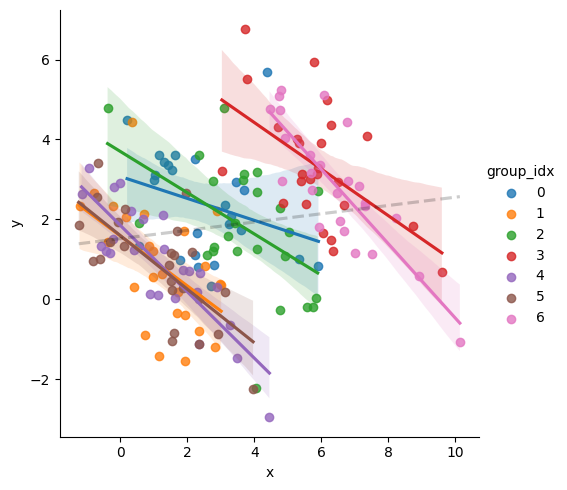

In [14]:
sns.lmplot(data=data, x="x", y="y", hue="group_idx", order=1)
sns.regplot(data=data, x="x", y="y",scatter=False,ci=None,line_kws=dict(color='k',ls="--",alpha=0.2))

As we know & saw in the lecture, this is how basic regression model looks:
$$y = \beta_0 + \beta_1 \cdot x$$

We will start by performing basic regression on all of our data, and treat it like one unit:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, β0, β1]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 55 seconds.


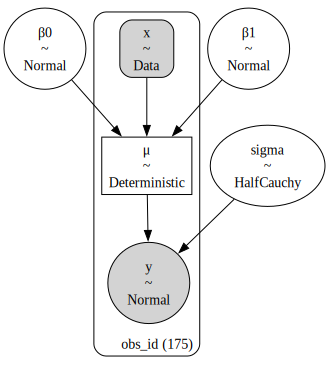

In [21]:
with pm.Model() as linear_regression:
    sigma = pm.HalfCauchy("sigma", beta=2)
    β0 = pm.Normal("β0", 0, sigma=5)
    β1 = pm.Normal("β1", 0, sigma=5)
    x = pm.Data("x", data.x, dims="obs_id")
    μ = pm.Deterministic("μ", β0 + β1 * x, dims="obs_id")
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")
    trace = pm.sample(2000, return_inferencedata=True)
pm.model_to_graphviz(linear_regression)

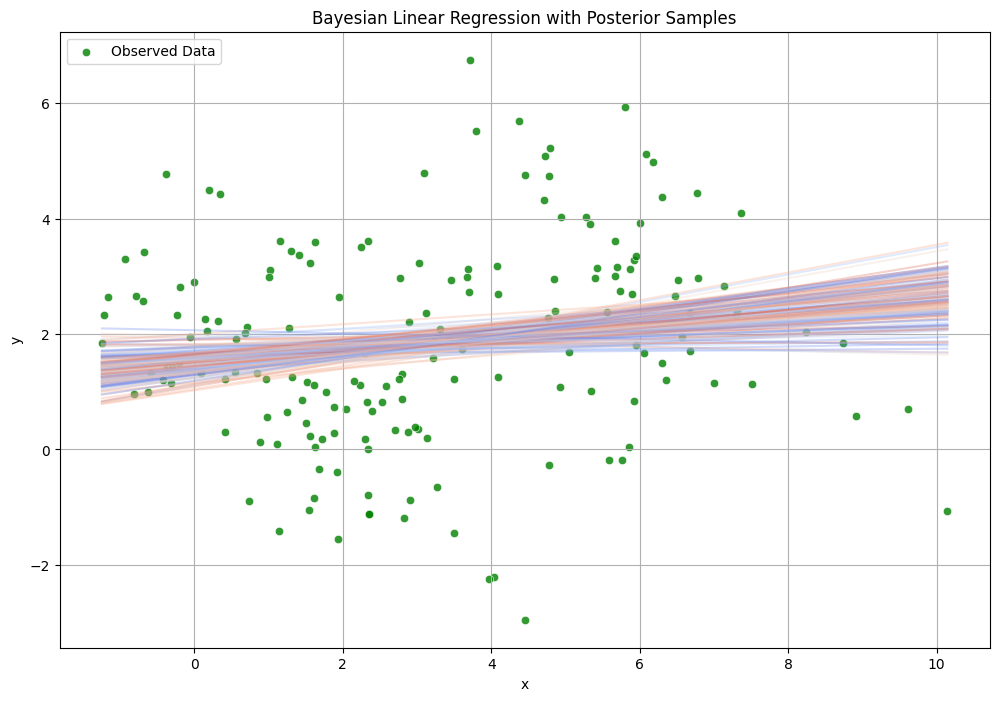

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Extract intercepts and slopes from the posterior samples
intercepts = trace.posterior["β0"].values.flatten()
slopes = trace.posterior["β1"].values.flatten()

# Generate a range of x values for predictions
x_range = np.linspace(data["x"].min(), data["x"].max(), 100)

# Create the plot
plt.figure(figsize=(12, 8))

# Scatter plot of the observed data
sns.scatterplot(data=data, x="x", y="y", color="green", label="Observed Data", alpha=0.8)

# Plot regression lines based on a subset of posterior samples
colors = sns.color_palette("coolwarm", as_cmap=False)  # Use a different color palette

# Plot every 50th sample to reduce crowding and use colors to distinguish lines
for i, (intercept, slope) in enumerate(zip(intercepts[::50], slopes[::50])):
    plt.plot(x_range, intercept + slope * x_range, color=colors[i % len(colors)], alpha=0.3)

# Add labels, title, and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian Linear Regression with Posterior Samples')
plt.legend(loc='upper left')
plt.grid(True)

# Show the plot
plt.show()

### Bayesian Linear Regression with Posterior Samples

The plot displays the results of a Bayesian linear regression, where the green scatter points represent the observed data points. The x-axis corresponds to the predictor variable `x`, while the y-axis corresponds to the response variable `y`.

The multiple lines plotted across the graph represent the regression lines based on samples from the posterior distributions of the intercept and slope. Each line is colored using a color gradient (from a purple-blue hue to red) to indicate the different posterior samples. The transparency of the lines helps to visualize the uncertainty in the posterior distribution.

The scatter of the posterior regression lines gives a sense of the uncertainty in the estimated relationship between `x` and `y`. However, an important point to notice is that while the lines generally fit the data, the model appears to miss a key feature: **group structure** in the data.

The model currently assumes that the data points are independent, but if the data is actually grouped (for example, by different categories or groups that may have their own intercepts and slopes), this approach would lose that information. The comment below the plot rightly points out that this linear model may not fully capture the group structure, and it would be necessary to adjust the model to account for this.

# but doing that, we are loosing the point, our data is in groups and we need to take this into acount.

we will perform basic regression on each group

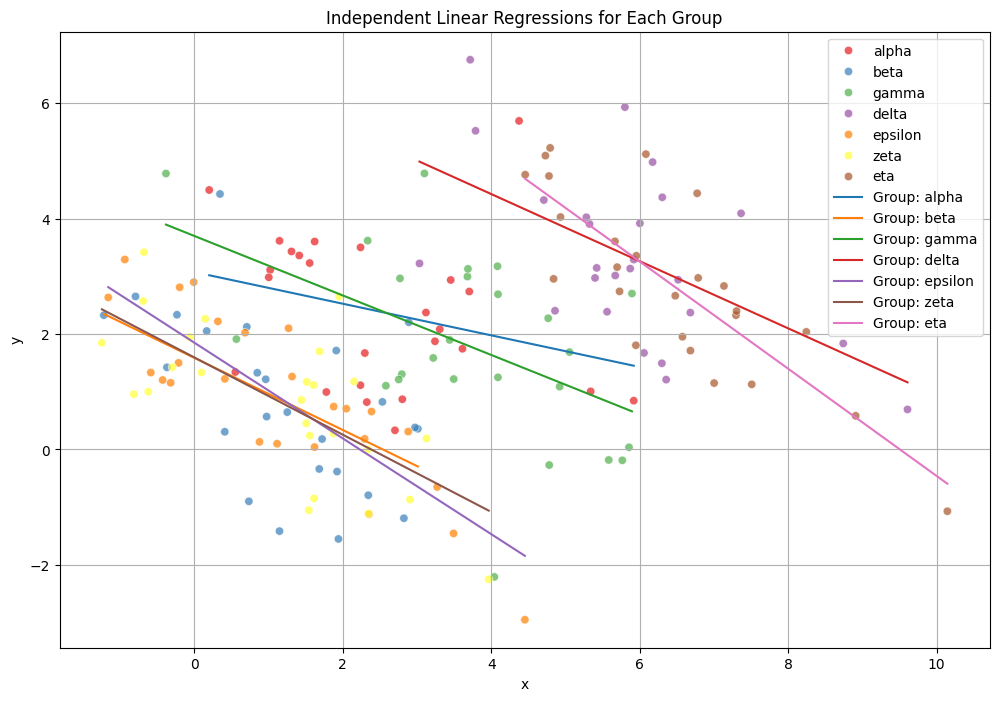

In [24]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fit a linear regression for each group separately
group_list = data['group'].unique()  # Unique groups

# Create a figure to plot each group's regression line
plt.figure(figsize=(12, 8))

# Plot data points for each group
sns.scatterplot(data=data, x="x", y="y", hue="group", palette="Set1", legend="full", alpha=0.7)

# Fit a separate OLS regression for each group
for group in group_list:
    group_data = data[data['group'] == group]
    
    # Prepare the data
    X = sm.add_constant(group_data['x'])  # Add intercept
    y = group_data['y']
    
    # Fit the OLS model
    model = sm.OLS(y, X).fit()
    
    # Get the slope and intercept
    intercept = model.params['const']
    slope = model.params['x']
    
    # Generate predictions over a range of x values
    x_range = np.linspace(group_data['x'].min(), group_data['x'].max(), 100)
    y_pred = intercept + slope * x_range
    
    # Plot the regression line for this group
    plt.plot(x_range, y_pred, label=f'Group: {group}')

# Customize the plot
plt.xlabel('x')
plt.ylabel('y')
plt.title('Independent Linear Regressions for Each Group')
plt.legend()
plt.grid(True)
plt.show()

### Hierarchical regression

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_mu, intercept_sigma, slope_mu, slope_sigma, sigma_hyperprior, β0, β1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 666 seconds.
There were 240 divergences after tuning. Increase `target_accept` or reparameterize.


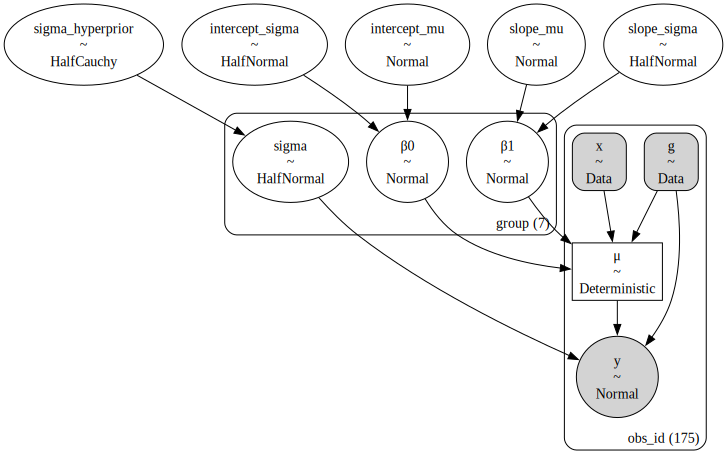

In [31]:
# Define the groups for the model
coords = {"group": group_list}

with pm.Model(coords=coords) as hierarchical:
    # Hyperpriors for group-level parameters
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=1)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=2)
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=2)
    sigma_hyperprior = pm.HalfCauchy("sigma_hyperprior", beta=2)  # Switched to HalfCauchy

    # Group-specific priors for intercept and slope
    β0 = pm.Normal("β0", intercept_mu, sigma=intercept_sigma, dims="group")
    β1 = pm.Normal("β1", slope_mu, sigma=slope_sigma, dims="group")

    # Group-specific noise term
    sigma = pm.HalfNormal("sigma", sigma=sigma_hyperprior, dims="group")

    # Data for observations and group identifiers
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")

    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")

    # Likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

    # Run the inference
    trace = pm.sample(3000, return_inferencedata=True)

# Visualize the model structure
pm.model_to_graphviz(hierarchical)

In [34]:
with hierarchical:
  idata = pm.sample(1000,chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept_mu, intercept_sigma, slope_mu, slope_sigma, sigma_hyperprior, β0, β1, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 293 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


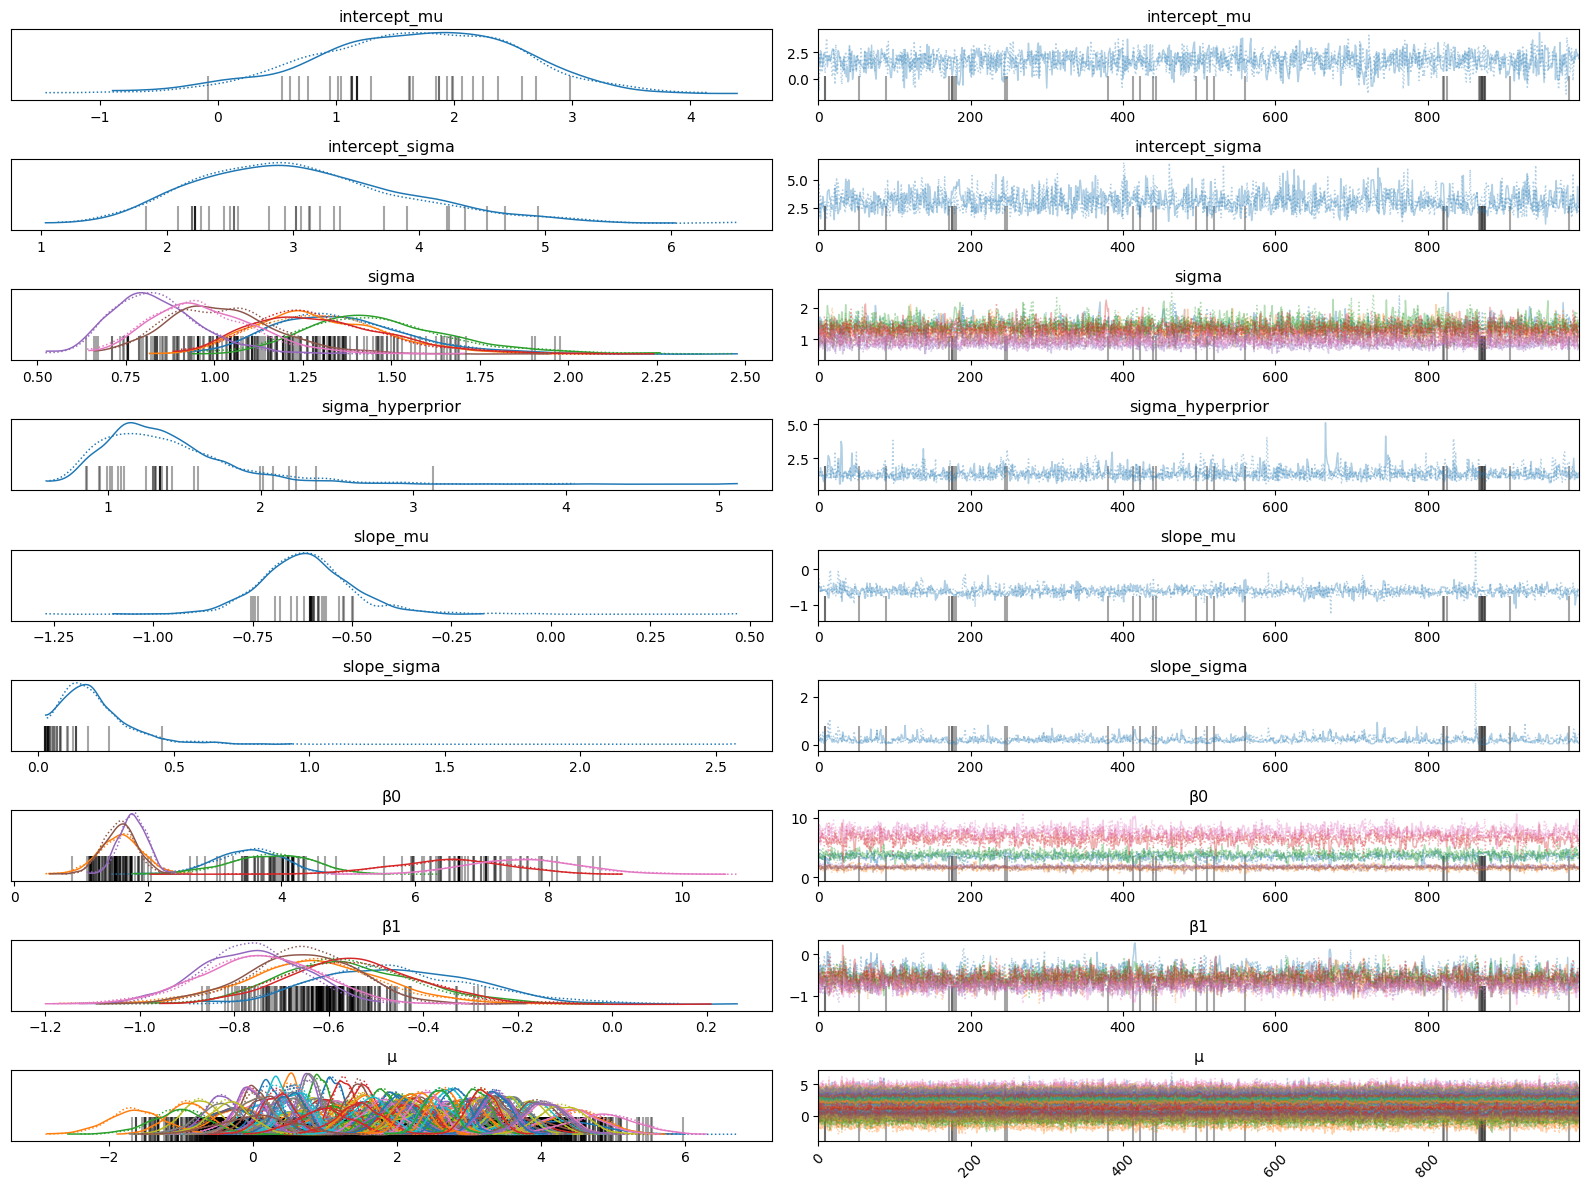

In [55]:
# Plot the trace
az.plot_trace(idata, figsize=(16, 12))  # Increase the figure size to 16x12

# Optional: If labels overlap, adjust the rotation of x and y labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to fit the plots and labels
plt.show()

## Plot Explanations

### 1. Intercept_mu
- **Posterior Distribution**: Shows the group-level mean for the intercepts, centered around 0 with some spread, indicating uncertainty.
- **Trace Plot**: Well-mixed and converged MCMC chains.

### 2. Intercept_sigma
- **Posterior Distribution**: Represents the variability of intercepts between groups. Peaks around 2.
- **Trace Plot**: Good mixing, showing proper exploration of parameter space.

### 3. Sigma (Shared Noise Term)
- **Posterior Distribution**: Shows the residual noise term shared across all observations, indicating the unexplained variance.
- **Trace Plot**: Consistent sampling across chains, showing reasonable mixing.

### 4. Sigma_hyperprior
- **Posterior Distribution**: Represents the prior on group-level standard deviations. Helps regularize group noise terms.
- **Trace Plot**: Stable and well-mixed, no major issues.

### 5. Slope_mu
- **Posterior Distribution**: Shows the group-level mean for the slopes. The peak is near -0.5, suggesting a slight negative slope on average.
- **Trace Plot**: Good convergence, well-mixed chains.

### 6. Slope_sigma
- **Posterior Distribution**: Shows the variability in slopes between different groups. The posterior indicates moderate variability.
- **Trace Plot**: Properly sampled with good mixing.

### 7. β0 (Group-Specific Intercepts)
- **Posterior Distribution**: Shows the intercepts for each group, with different groups having their own intercept distribution.
- **Trace Plot**: Group-specific intercepts are well sampled with good mixing.

### 8. β1 (Group-Specific Slopes)
- **Posterior Distribution**: Shows the slopes for each group. Some groups have steeper slopes, indicating different relationships between `x` and `y` across groups.
- **Trace Plot**: Well-mixed chains for group-specific slopes.

### 9. μ (Linear Model for Each Group)
- **Posterior Distribution**: Shows the overall linear model for each group, incorporating both intercept and slope for each group.
- **Trace Plot**: Good convergence, indicating the model has properly captured the linear relationships.

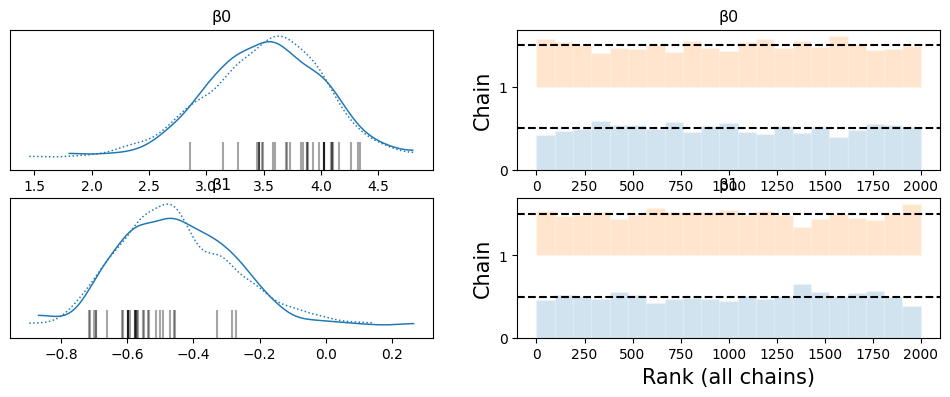

In [54]:
az.plot_trace(idata, kind="rank_bars", var_names=["β0", "β1"],coords = {"group": "alpha"},  figsize = (12, 4));

* Rank Histogram (Left): The rank histograms are mostly uniform, showing good mixing and convergence of the model for both β0 (intercept) and β1 (slope), with only minor deviations.
* Rank Bars (Right): The rank bars across chains are well-distributed, indicating effective chain mixing and balanced contributions from each chain.


<Axes: xlabel='β0', ylabel='β1'>

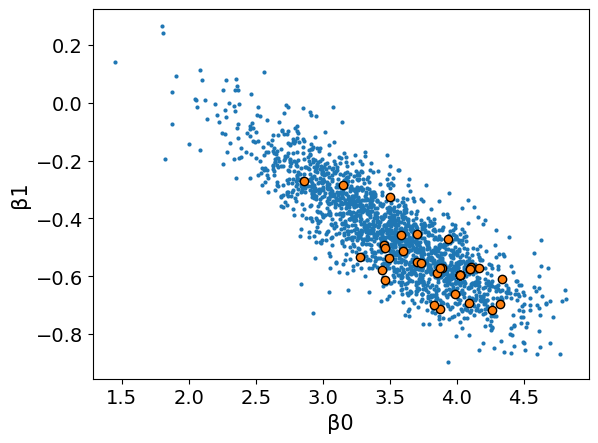

In [53]:
az.plot_pair(idata, var_names=["β0", "β1"], coords={"group": "alpha"}, kind='scatter', divergences=True)

<Axes: title={'center': 'β1'}, xlabel='Quantile', ylabel='ESS for small intervals'>

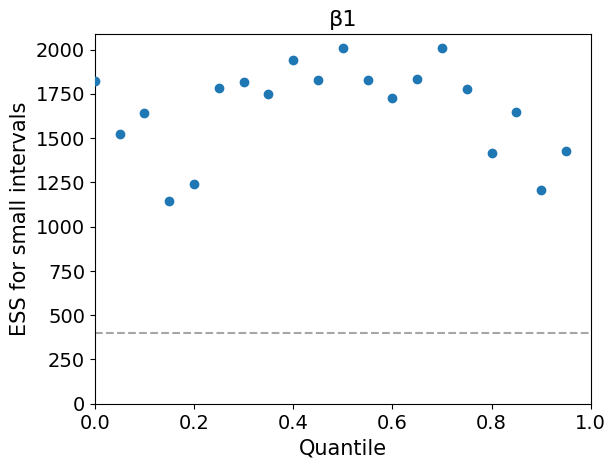

In [43]:
az.plot_ess(idata,var_names=["β1"],coords = {"group": "alpha"})

<Axes: title={'center': 'β1'}, xlabel='Total number of draws', ylabel='ESS'>

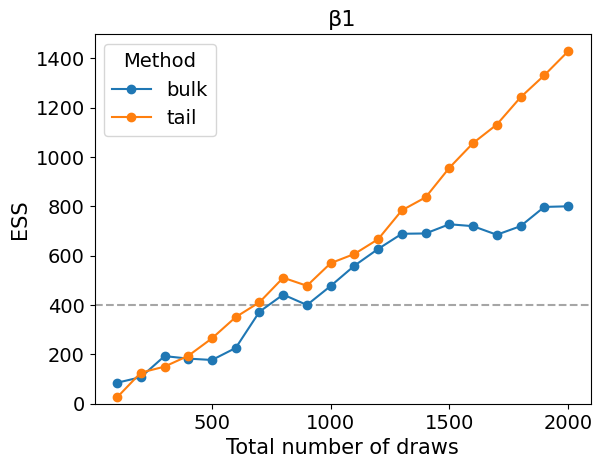

In [44]:
az.plot_ess(idata,var_names=["β1"],coords = {"group": "alpha"},kind='evolution')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_mu, intercept_sigma, slope_mu, slope_sigma, sigma_hyperprior, β0_offset, β1_offset, sigma]


Output()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytensor/scalar/basic.py:3200: RuntimeWarning: overflow encountered in scalar multiply
  return x * x
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytensor/scalar/basic.py:3094: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytensor/scalar/basic.py:3200: RuntimeWarning: overflow encountered in scalar multiply
  return x * x
/Library/Frameworks/Python.fra

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 960 seconds.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.


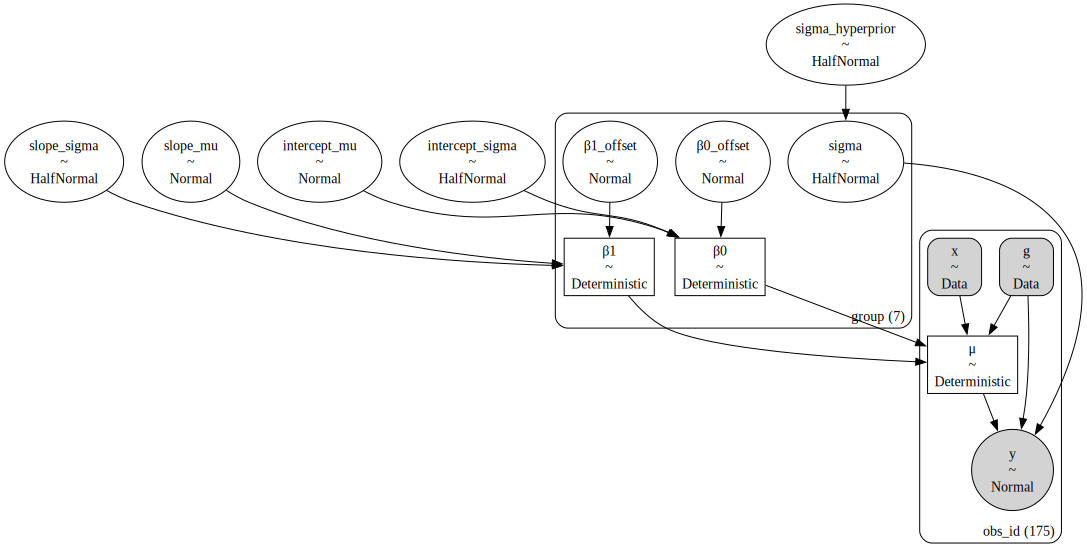

In [45]:
import pymc as pm
import numpy as np
import arviz as az

# Define the groups for the model (adjust according to your dataset)
coords = {"group": group_list}  # 'group_list' is the list of group names

# Hierarchical non-centered model definition
with pm.Model(coords=coords) as hierarchical_nc:  # non-centered parameterization
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=1)  # Mean intercept across groups
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=2)  # Std dev for intercept
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)  # Mean slope across groups
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=2)  # Std dev for slope
    sigma_hyperprior = pm.HalfNormal("sigma_hyperprior", sigma=0.5)  # Std dev for residuals/noise

    # Group-specific priors for intercept and slope with non-centered parameterization
    β0_offset = pm.Normal("β0_offset", 0, sigma=1, dims="group")  # Non-centered intercept
    β0 = pm.Deterministic("β0", intercept_mu + β0_offset * intercept_sigma, dims="group")  # Centered intercept
    β1_offset = pm.Normal("β1_offset", 0, sigma=1, dims="group")  # Non-centered slope
    β1 = pm.Deterministic("β1", slope_mu + β1_offset * slope_sigma, dims="group")  # Centered slope
    
    # Group-specific standard deviation for residuals/noise
    sigma = pm.HalfNormal("sigma", sigma=sigma_hyperprior, dims="group")

    # Data: predictor (x) and group index (g)
    x = pm.MutableData("x", data.x, dims="obs_id")  # predictor variable
    g = pm.MutableData("g", data.group_idx, dims="obs_id")  # group index
    
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")  # Linear model for each group
    
    # Define likelihood with observed data
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")
    
    # Run the inference
    trace = pm.sample(2000, return_inferencedata=True)

# Visualize the model structure
pm.model_to_graphviz(hierarchical_nc)

In [56]:
with hierarchical_nc:
  idata_nc = pm.sample(1000,chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept_mu, intercept_sigma, slope_mu, slope_sigma, sigma_hyperprior, β0_offset, β1_offset, sigma]


Output()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytensor/scalar/basic.py:3094: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytensor/scalar/basic.py:3094: RuntimeWarning: overflow encountered in exp
  return np.exp(x)


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 646 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [57]:
az.summary(idata_nc,var_names=["β1"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β1[alpha],-0.467,0.168,-0.771,-0.162,0.005,0.004,1086.0,972.0,1.0
β1[beta],-0.625,0.144,-0.873,-0.332,0.003,0.002,1895.0,1314.0,1.0
β1[gamma],-0.563,0.146,-0.814,-0.261,0.004,0.003,1298.0,960.0,1.0
β1[delta],-0.553,0.145,-0.829,-0.284,0.006,0.004,804.0,317.0,1.0
β1[epsilon],-0.753,0.102,-0.937,-0.558,0.003,0.002,1398.0,1611.0,1.0
β1[zeta],-0.652,0.121,-0.884,-0.427,0.002,0.002,2408.0,1483.0,1.0
β1[eta],-0.739,0.124,-0.971,-0.500,0.004,0.003,1114.0,1200.0,1.0


In [58]:
az.summary(idata_nc,var_names=["β0"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β0[alpha],3.541,0.496,2.638,4.485,0.017,0.012,904.0,1075.0,1.0
β0[beta],1.600,0.307,1.027,2.211,0.007,0.005,1692.0,1257.0,1.0
β0[gamma],3.859,0.624,2.698,5.028,0.017,0.012,1421.0,818.0,1.0
β0[delta],6.548,0.891,4.798,8.167,0.033,0.023,927.0,323.0,1.0
β0[epsilon],1.768,0.202,1.391,2.155,0.005,0.004,1483.0,1799.0,1.0
β0[zeta],1.569,0.244,1.080,2.010,0.005,0.004,2035.0,1831.0,1.0
β0[eta],7.578,0.820,5.995,9.049,0.024,0.017,1169.0,1290.0,1.0
